# Multi Class Object Detection
* Perform multi class object detection in a subset of the Caltech 101 dataset: http://www.vision.caltech.edu/Image_Datasets/Caltech101/
* The dataset used for the experiments consists of 3 object categories: octopus, butterfly and hedgehog.
* For the object detection, we will perform transfer learning using the VGG16 model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scipy.io
import pandas as pd
import sys
import os
from os.path import join as jp
import numpy as np
import csv
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from imutils import paths

## Prepare dataset 

In [ ]:
data = []
labels = []
bboxes = []
imagePaths = []

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

image_path = "/content/drive/MyDrive/Colab Notebooks/Multi_Class_Object_Detection/objects"
csv_path = "/content/drive/MyDrive/Colab Notebooks/Multi_Class_Object_Detection/annotations2"

data = []
labels = []
bboxes = []
imagePaths = []

for csvfile in os.listdir(csv_path):
  print("Preparing", csvfile, "....")

  file = jp(csv_path,csvfile)

  # Load csv
  rows = open(file).read().strip().split("\n")
  
  # Load csv info
  for row in rows:
    row = row.split(",")
    (filename, startX, startY, endX, endY, label) = row

    # Load image
    imagePath = jp(image_path, label, filename)
    image = cv2.imread(imagePath)

    # Get image dimensions (height, width)
    (h, w) = image.shape[:2] 

    # Scale bbox coordinates relative to spatial image dimensions to the range [0, 1] 
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h

    # Resize image to (224, 224, 3)
    resized_image = load_img(imagePath, target_size=(224, 224))
    resized_image = img_to_array(resized_image) / 255

    # Save
    data.append(np.asarray(resized_image))
    labels.append(label)
    bboxes.append((startX, startY, endX, endY))
    imagePaths.append(imagePath)


  print("DONE\n")

data = np.array(data, dtype="float32") 
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)


print("Images:",data.shape)
print("Image values in range:", data.min(),"-",data.max())
print("Labels:",labels.shape)
print("BBoxes:",bboxes.shape)
print("Bboxes values in range:", bboxes.min(),"-",bboxes.max())
print("Image paths:",imagePaths.shape)



Preparing octopus.csv ....
DONE

Preparing hedgehog.csv ....
DONE

Preparing butterfly.csv ....
DONE

Images: (180, 224, 224, 3)
Image values in range: 0.0 - 1.0
Labels: (180,)
BBoxes: (180, 4)
Bboxes values in range: 0.0033333334 - 1.0
Image paths: (180,)


#### One-hot encode labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from numpy import asarray

labels_onehot = np.asarray(labels)
labels_onehot = labels_onehot[..., np.newaxis]

encoder = OneHotEncoder(sparse=False)
labels_onehot = encoder.fit_transform(labels_onehot)

print(labels_onehot.shape)

(180, 3)


#### Split into train, test, validation sets

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

# Split into train-test
trainImages, testImages, trainLabels, testLabels, trainBBoxes, testBBoxes, trainPaths, testPaths = train_test_split(data, labels_onehot, bboxes, imagePaths, test_size=0.050, random_state=42)

# Split into val
trainImages, valImages, trainLabels, valLabels, trainBBoxes, valBBoxes, trainPaths, valPaths = train_test_split(trainImages, trainLabels, trainBBoxes, trainPaths, test_size=0.20, random_state=42)

print("Train data..")
print(trainImages.shape)
print(trainLabels.shape)
print(trainBBoxes.shape)
print("\n")
print("Test data..")
print(testImages.shape)
print(testLabels.shape)
print(testBBoxes.shape)
print("\n")
print("Val data..")
print(valImages.shape)
print(valLabels.shape)
print(valBBoxes.shape)

Train data..
(136, 224, 224, 3)
(136, 3)
(136, 4)


Test data..
(9, 224, 224, 3)
(9, 3)
(9, 4)


Val data..
(35, 224, 224, 3)
(35, 3)
(35, 4)


#### Save test data names in txt file

In [ ]:
# Convert one-hot test labels back to original
encoded_cat = encoder.categories_[0]

testLabels = np.argmax(testLabels, axis=1)
testLabels = encoded_cat[testLabels]

test_data_path = "/content/drive/MyDrive/Colab Notebooks/Multi_Class_Object_Detection/test_data.txt"
f = open(test_data_path, "w")
f.write("\n".join(testPaths))
f.close()

test_labels_path = "/content/drive/MyDrive/Colab Notebooks/Multi_Class_Object_Detection/test_data_labels.txt"
f2 = open(test_labels_path, "w")
f2.write("\n".join(testLabels))
f2.close()



## Create object detection model
* We download the pretrained VGG16 architecture, freeze the top layers and construct a two branch output for object classification and bbox regression.
* The final model predicts the class label and the bbox coordinates for the object.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical


#### Load the pretrained VGG16 model

In [ ]:
# Load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze layers
vgg.trainable = False

# Flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

#### Prepare multi-output (two-branch) model for multi-class bounding box regression

In [ ]:
# FC layer for bbox prediction
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",	name="bounding_box")(bboxHead)

# FC layer for class prediction
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(3, activation="softmax",	name="class_label")(softmaxHead)
 
# Construct two-layer model
model = Model(inputs=vgg.input,
	            outputs=(bboxHead, softmaxHead))

In [ ]:
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error"}


lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0}

# Compile
opt = Adam(learning_rate = 0.0001)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
# print(model.summary())

## Train

In [ ]:
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes}

valTargets = {
	"class_label": valLabels,
	"bounding_box": valBBoxes}

In [ ]:
history = model.fit(
	trainImages, trainTargets,
	validation_data=(valImages, valTargets),
	batch_size=32,
	epochs=20,
	verbose=1)

Epoch 1/20
5/5 [==============================] - 94s 19s/step - loss: 1.3344 - bounding_box_loss: 0.0588 - class_label_loss: 1.2755 - bounding_box_accuracy: 0.3897 - class_label_accuracy: 0.4191 - val_loss: 0.6039 - val_bounding_box_loss: 0.0063 - val_class_label_loss: 0.5976 - val_bounding_box_accuracy: 0.4857 - val_class_label_accuracy: 0.7714
Epoch 2/20
5/5 [==============================] - 111s 23s/step - loss: 0.6676 - bounding_box_loss: 0.0083 - class_label_loss: 0.6593 - bounding_box_accuracy: 0.5074 - class_label_accuracy: 0.7059 - val_loss: 0.2919 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.2851 - val_bounding_box_accuracy: 0.5714 - val_class_label_accuracy: 0.9429
Epoch 3/20
5/5 [==============================] - 114s 23s/step - loss: 0.4219 - bounding_box_loss: 0.0098 - class_label_loss: 0.4121 - bounding_box_accuracy: 0.6176 - class_label_accuracy: 0.8382 - val_loss: 0.2213 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.2146 - val_bounding_box_acc

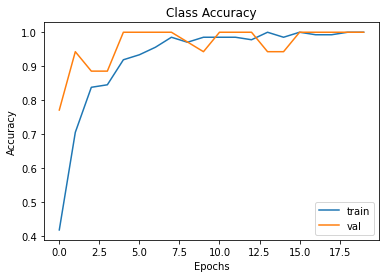

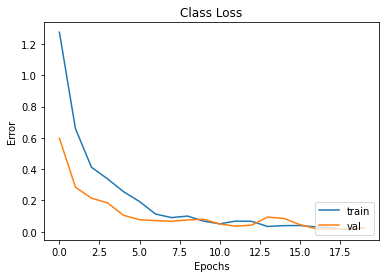

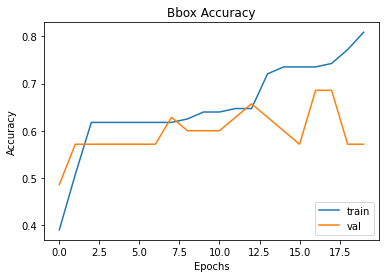

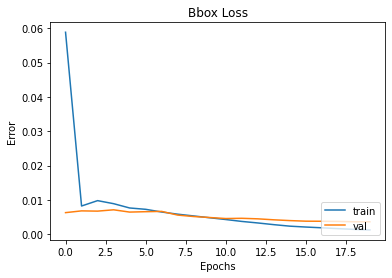

In [ ]:
 # Accuracy plot
plt.plot(history.history["class_label_accuracy"], label="train")
plt.plot(history.history["val_class_label_accuracy"], label="val")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc="lower right")
plt.title("Class Accuracy")
plt.show()

plt.plot(history.history["class_label_loss"], label="train")
plt.plot(history.history["val_class_label_loss"], label="val")
plt.ylabel("Error")
plt.xlabel("Epochs")
plt.legend(loc="lower right")
plt.title("Class Loss")
plt.show()

plt.plot(history.history["bounding_box_accuracy"], label="train")
plt.plot(history.history["val_bounding_box_accuracy"], label="val")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc="lower right")
plt.title("Bbox Accuracy")
plt.show()

plt.plot(history.history["bounding_box_loss"], label="train")
plt.plot(history.history["val_bounding_box_loss"], label="val")
plt.ylabel("Error")
plt.xlabel("Epochs")
plt.legend(loc="lower right")
plt.title("Bbox Loss")
plt.show()

# print(model.metrics_names)

## Predict

Predicting for:  image_0015.jpg
Ground truth label: octopus
Predicted label: [2] --> ['octopus']




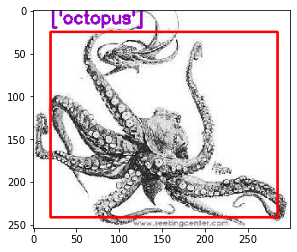




Predicting for:  image_0027.jpg
Ground truth label: hedgehog
Predicted label: [1] --> ['hedgehog']




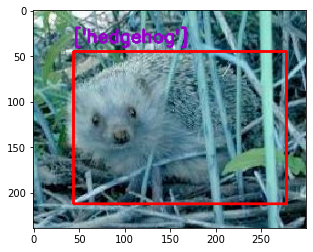




Predicting for:  image_0075.jpg
Ground truth label: butterfly
Predicted label: [0] --> ['butterfly']




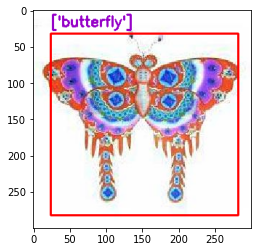




Predicting for:  image_0054.jpg
Ground truth label: hedgehog
Predicted label: [1] --> ['hedgehog']




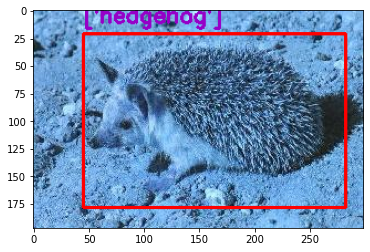




Predicting for:  image_0030.jpg
Ground truth label: butterfly
Predicted label: [0] --> ['butterfly']




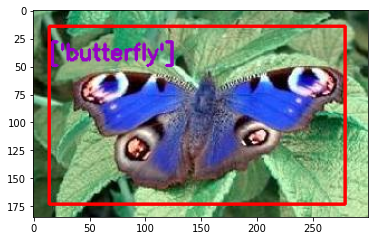




Predicting for:  image_0024.jpg
Ground truth label: octopus
Predicted label: [2] --> ['octopus']




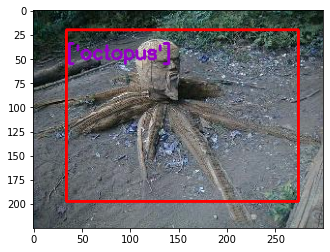




Predicting for:  image_0028.jpg
Ground truth label: octopus
Predicted label: [2] --> ['octopus']




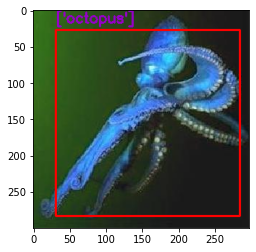




Predicting for:  image_0013.jpg
Ground truth label: hedgehog
Predicted label: [1] --> ['hedgehog']




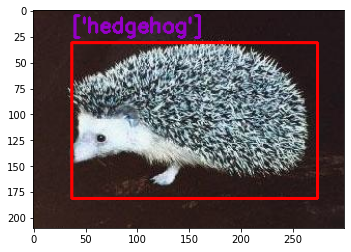




Predicting for:  image_0007.jpg
Ground truth label: butterfly
Predicted label: [0] --> ['butterfly']




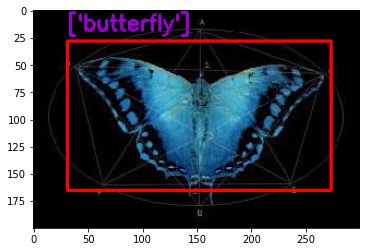

In [ ]:
encoded_cat = encoder.categories_[0]

test_images = open(test_data_path).read().strip().split("\n")
test_labels = open(test_labels_path).read().strip().split("\n")

cnt = 0

# Load test image
for imagePath in test_images:

  # Load image, preprocess and predict
  print("Predicting for: ", imagePath[-14:])
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image) / 255.0
  image = np.expand_dims(image, axis=0)

  print("Ground truth label:", test_labels[cnt] )
  cnt = cnt +1

  (boxPreds, labelPreds) = model.predict(image)
  (startX, startY, endX, endY) = boxPreds[0]

  lbl = np.argmax(labelPreds, axis=1)
  print("Predicted label:", lbl, "-->", encoded_cat[lbl])
  print("\n")

  # Plots  
  image = cv2.imread(imagePath)
  (h, w) = image.shape[:2]

  # Scale predicted bbox coordinates based on the image dimensions
  startX = int(startX * w)
  startY = int(startY * h)
  endX = int(endX * w)
  endY = int(endY * h)

  # Draw the predicted bounding box and class label on the image
  cv2.rectangle(image, (startX, startY), (endX, endY), (255, 0, 0), 2)

  y = startY - 10 if startY - 10 > 10 else startY + 30
  cv2.putText(image, str(encoded_cat[lbl]), (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (150, 0, 200), 2)

  # show the output image
  plt.imshow(image)
  plt.show()

  print("\n\n")

